In [1]:
%matplotlib inline
from netCDF4 import Dataset
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from spharm import Spharmt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
cmap = ListedColormap(sns.color_palette("coolwarm", 9).as_hex())
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 0.6

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = 'line'
matplotlib.rcParams['axes.labelsize'] = 7

matplotlib.rcParams['grid.linestyle'] = '-.'
matplotlib.rcParams['grid.linewidth'] = 0.4

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 0.7

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.7


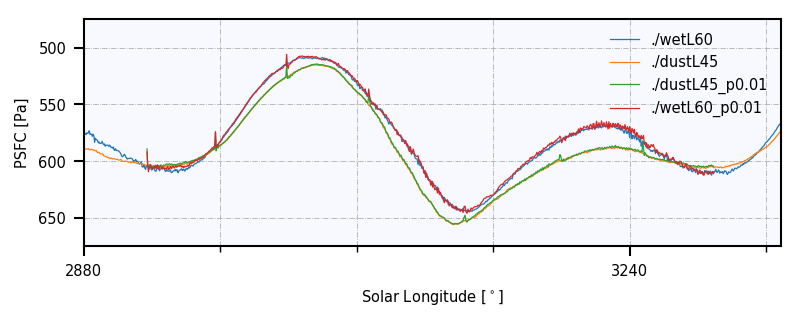

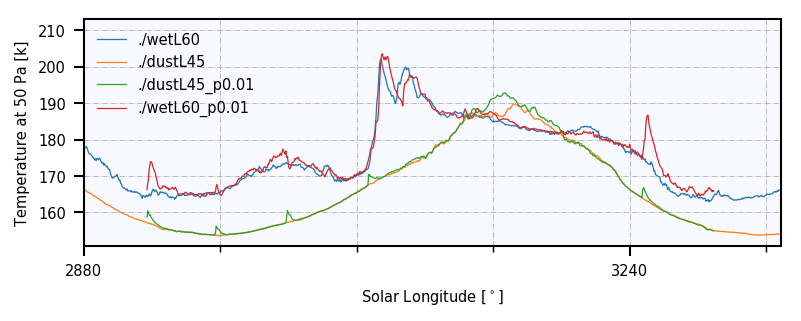

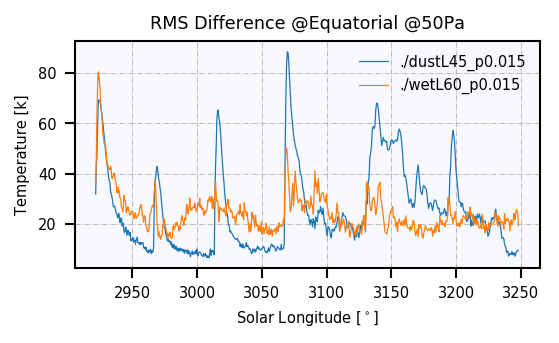

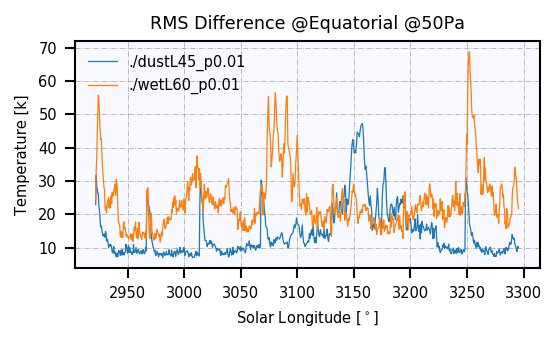

In [10]:
from netCDF4 import Dataset

major_ticks = np.arange(0, 360*10, 360)  

def yearly_ls(ls):
    idx = np.where(ls==360)[0]
    counter = 1
    for i in np.arange(idx.size-1):
        ls[idx[i]:idx[i+1]] += counter*360
        ls[idx[i]] -= 360
        counter += 1
    if idx.size == 1:
        i = 0
        ls[idx[i]:] += counter*360
        ls[idx[i]] -= 360
    else:
        ls[idx[i+1]:] += counter*360
        ls[idx[i+1]] -= 360
    return ls

# wet data
filedir_d = './wetL60_test.nc'
data = Dataset(filedir_d,'r')
psfcwet = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
twet = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
ls = data.variables['LS'][:]
ls = yearly_ls(ls)

# dust data
filedir_w = './dustL45_test.nc'
data = Dataset(filedir_w,'r')
psfcdust = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
tdust = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lsdust = data.variables['LS'][:]
lsdust = yearly_ls(lsdust)

# dust perturbation high res scale
filedir_dp = './dustL45_p0.01.nc'
data = Dataset(filedir_dp,'r')
psfcdustp = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
tdustp = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lsdustp = data.variables['LS'][:] 
lsdustp = yearly_ls(lsdustp) + 2880


# dust perturbation high res scale
filedir_wp = './wetL60_p0.01.nc'
data = Dataset(filedir_wp,'r')
psfcwetp = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
twetp = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lswetp = data.variables['LS'][:]
lswetp = yearly_ls(lswetp) + 2880


# print (np.where(lsdust==lsdustp[0]), 'test')
# lsdust = lsdust[:6690]

full_arr = 2000
fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], psfcwet[:], label=filedir_d.replace('_test.nc',''))
plot(lsdust[:], psfcdust, label=filedir_w.replace('_test.nc',''))
plot(lsdustp[:],psfcdustp, label=filedir_dp.replace('.nc',''))
plot(lswetp[:],psfcwetp, label=filedir_wp.replace('.nc',''))
ylabel('PSFC [Pa]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
xlim([2880,3340])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
ylim([675,475])
legend()

fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], twet[:], label=filedir_d.replace('_test.nc',''))
plot(lsdust[:],tdust, label=filedir_w.replace('_test.nc',''))
plot(lsdustp[:],tdustp, label=filedir_dp.replace('.nc',''))
plot(lswetp[:],twetp, label=filedir_wp.replace('.nc',''))
ylabel('Temperature at 50 Pa [k]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
xlim([2880,3340])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
legend()

def rmsTimeseries(rawfiledir, pertfiledir, pert):
    
    data = Dataset(rawfiledir,'r')
    ls = data.variables['LS'][:]
    ls = yearly_ls(ls)
    tsk = data.variables['T50Pa'][:]#[:,17:20].mean(axis=2).mean(axis=1)
#     psfc = data.variables['PSFC'][:]
#     zmT = data.variables['T'][:][:,25:30].mean(axis=1)
    
    data = Dataset(pertfiledir,'r')
    lsp = data.variables['LS'][:]
    lsp = yearly_ls(lsp) + 2880
    tskp = data.variables['T50Pa'][:]#[:,17:20].mean(axis=2).mean(axis=1)
#     psfcp = data.variables['PSFC'][:]
#     zmTp = data.variables['T'][:][:,25:30].mean(axis=1)
    
    idx = np.where(ls==lsp[0])[0][0]
    idx2 = np.where(ls==lsp[-1])[0][0]
    
    tsk = tsk[idx:idx2+1]
    equatorial_rms = np.sqrt(np.abs(tsk**2-tskp**2))[:,17:20].mean(axis=2).mean(axis=1)
    
    plot(lsp, equatorial_rms, label=pertfiledir.replace('.nc',''))
    title("RMS Difference @Equatorial @50Pa")
    ylabel("Temperature [k]")
    xlabel("Solar Longitude [$^\circ$]")
    legend()

fig, ax = plt.subplots(figsize=(4,2))
rmsTimeseries('./dustL45_test.nc', './dustL45_p0.015.nc', "0.01")
rmsTimeseries('./wetL60_test.nc', './wetL60_p0.015.nc', "0.015")

fig, ax = plt.subplots(figsize=(4,2))
rmsTimeseries('./dustL45_test.nc', './dustL45_p0.01.nc', "0.01")
rmsTimeseries('./wetL60_test.nc', './wetL60_p0.01.nc', "0.015")

(36, 2)


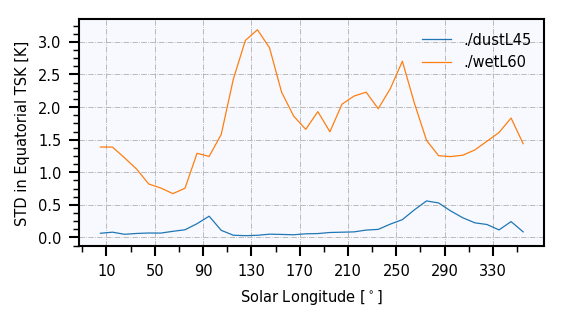

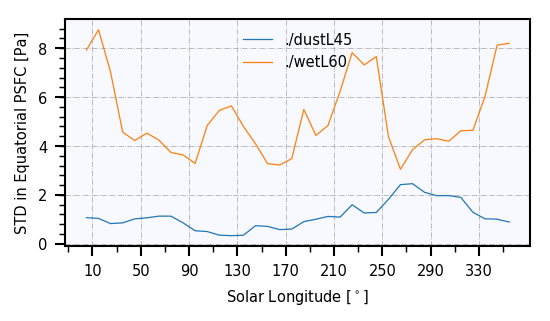

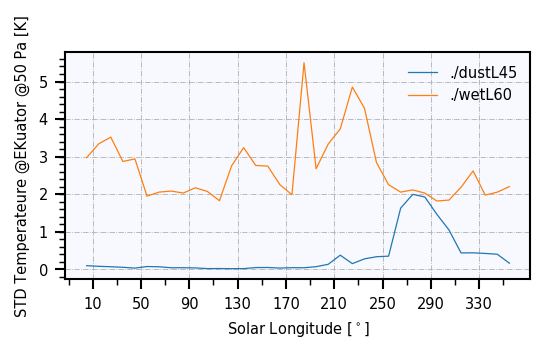

In [36]:
filedir = './wetL60_test.nc'
data = Dataset(filedir,'r')
lswet = data.variables['LS'][:]
psfcwet = data.variables['PSFC'][:]#[:,17:20].mean(axis=2).mean(axis=1)
tskwet = data.variables['TSK'][:]
twet = data.variables['T50Pa'][:]

filedir = './dustL45_test.nc'
data = Dataset(filedir,'r')
lsdust = data.variables['LS'][:]#[:6690]
psfcdust = data.variables['PSFC'][:]#[:,17:20].mean(axis=1)
tskdust = data.variables['TSK'][:]
tdust = data.variables['T50Pa'][:]

def meanSTD(ls, period, i, data):
    # indexes corresponding to certain period
    idx = np.where(abs(ls-(i*period+period/2))<period/2)[0]

    # indexes corresponding to another year 
    idx_year = np.where(np.diff(idx)>1)[0]
    tmp = []
    for j in np.arange(idx_year.size):
        if j == 0:
            tmp.append( data[idx[0:idx_year[j]+1]].mean(axis=0) )
        if j == idx_year.size-1:
            tmp.append( data[idx[idx_year[j]+1:]].mean(axis=0) )
        else:
            tmp.append( data[idx[idx_year[j]+1:idx_year[j+1]+1]].mean(axis=0) )
    tmp = np.array(tmp)
    return tmp.std(axis=0).mean()

period = 10
ndata = int(360/period)
vart = np.zeros((ndata,2)) # shape depending on the period
varp = np.zeros((ndata,2)) # shape depending on the period
vart50_stdzm = np.zeros((ndata,2)) # shape depending on the period

for i in np.arange(ndata):
    test = meanSTD(lsdust, period, i, psfcdust)
    test2 = meanSTD(lswet, period, i, psfcwet)
    varp[i] = [test,test2]
    
    test = meanSTD(lsdust, period, i, tdust[:,17:20].mean(axis=2).mean(axis=1))
    test2 = meanSTD(lswet, period, i, twet[:,17:20].mean(axis=2).mean(axis=1))
    vart50_stdzm[i] = [test,test2]
    
    test = meanSTD(lsdust, period, i, tskdust)
    test2 = meanSTD(lswet, period, i, tskwet)
#     test3 = find_idx_period(ls, period, i, twet)
    vart[i] = [test,test2]

print (varp.shape)

fig, ax = plt.subplots(figsize=(4,2))
major_ticks = np.arange(10,370,40)
xaxis = np.arange(5,365,period)
# plot(xaxis,vart[:,2], label='./wetL60')
plot(xaxis, vart[:,0], label='./dustL45')
plot(xaxis,vart[:,1], label='./wetL60')
xticks(major_ticks)
ylabel('STD in Equatorial TSK [K]')
xlabel('Solar Longitude [$^\circ$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# ax.grid(True, which='both')
legend()

fig, ax = plt.subplots(figsize=(4,2))
major_ticks = np.arange(10,370,40)
xaxis = np.arange(5,365,period)
# plot(xaxis,varp[:,2], label='./wetL60')
plot(xaxis, varp[:,0], label='./dustL45')
plot(xaxis,varp[:,1], label='./wetL60')
xticks(major_ticks)
ylabel('STD in Equatorial PSFC [Pa]')
xlabel('Solar Longitude [$^\circ$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(True, which='both')
legend()

fig, ax = plt.subplots(figsize=(4,2))
major_ticks = np.arange(10,370,40)
xaxis = np.arange(5,365,period)
# plot(xaxis,varp[:,2], label='./wetL60')
plot(xaxis, vart50_stdzm[:,0], label='./dustL45')
plot(xaxis,vart50_stdzm[:,1], label='./wetL60')
xticks(major_ticks)
ylabel('STD Temperateure @Equator @50 Pa [K]')
xlabel('Solar Longitude [$^\circ$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(True, which='both')
legend()



In [ ]:
idx[0].reshape((10,40))

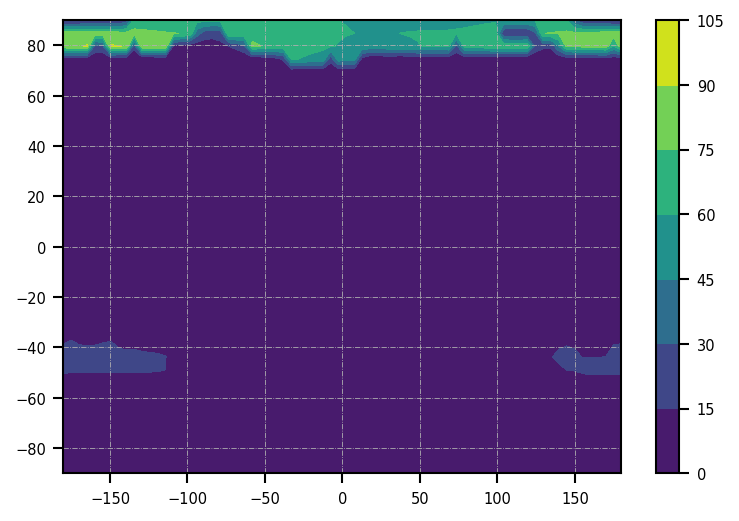

In [68]:
def animatedDiff(old_data, new_data):
    import matplotlib.animation as animation
    FFwriter = animation.FFMpegWriter()
    
    fig = plt.figure()
    
    images = []
    for i in tqdm(np.arange(new_data.shape[0])[500:]):
        im = plt.contourf(np.linspace(-180,180,72), np.linspace(-90,90,36), np.abs(old_data[4800+i]-new_data[i]))
#         im = im.collections
        def setvisible(self,vis):
            for c in self.collections: c.set_visible(vis)
        def setanimated(self,ani):
            for c in self.collections: c.set_animated(ani)
                
        im.set_visible = types.MethodType(setvisible,im)
        im.set_animated = types.MethodType(setanimated,im)
        im.axes = plt.gca()
        im.figure=fig
    
#         plt.colorbar()
        images.append([im])
    
    ani = animation.ArtistAnimation(fig, images, interval=70, blit=False,repeat_delay=1000)
#     ani.save('basic_animation.mp4', writer = FFwriter)
    ani.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    plt.show()
    

# dust data
filedir = './dustL45_test.nc'
data = Dataset(filedir,'r')
psfc = data.variables['TSK'][:]
t = data.variables['T50Pa'][:]
ls = data.variables['LS'][:]
ls = yearly_ls(ls)

# dust perturbation high res scale
filedir = './dustL45_p0.01.nc'
data = Dataset(filedir,'r')
psfcp = data.variables['TSK'][:]
tp = data.variables['T50Pa'][:]
lsp = data.variables['LS'][:]
lsp = yearly_ls(lsp) + 2880


idx = np.where(ls==lsp[0])[0][0]
idx2 = np.where(ls==lsp[-1])[0][0]

# figure(1)
# contourf(np.arange(psfcp.shape[0]), np.linspace(-180,180,72), np.sqrt(np.abs(psfc[idx:idx2+1,30]**2-psfcp[:,30]**2)).T)
# #xlim([0,50])
# colorbar()

figure(2)
contourf(np.linspace(-180,180,72), np.linspace(-90,90,36), (np.abs(psfc[4980]-psfcp[100])))
colorbar()

# animatedDiff(psfc, psfcp)


In [ ]:
fig = plt.figure()
import matplotlib.animation as animation
def animate(i): 
    if i%20 ==0: print (i)
    z = np.abs(t[4880+(i*5)] - tp[i*5]) 
    cont = plt.contourf(z, np.linspace(0,40,21))
    title('Sols {}'.format(i*5))
#     if (tslice == 0)
#         plt.title(r't = %1.2e' % t[i] )
#     else:
#         plt.title(r't = %i' % i)

    return cont
anim = animation.FuncAnimation(fig, animate, frames=120)
anim.save('animation.mp4')

0
0
20
40
60
80
100


In [ ]:
print (np.where(lsdust==lsdustp[0]))
print (np.where(lsdust==lsdustp[-1]))
print(psfcdust.shape)
print(psfcdustp.shape)